In [60]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from bokeh.plotting import figure, output_notebook,show, ColumnDataSource
from bokeh.layouts import widgetbox
from bokeh.models.widgets import DataTable, NumberFormatter, TableColumn
output_notebook()

from k_fold import *
from proj1_helpers import *
from implementations import *
from helpers import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Data exploration

In [2]:
y, x, ids = load_csv_data('../data/train.csv')
labels = np.array(np.genfromtxt('../data/train.csv', delimiter=",", names=True).dtype.names[2:])

In [99]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)
corr[:,0]
filter_ = [idx for idx, label in enumerate(labels) if not 'phi' in label]
x[:, filter_].shape

(250000, 24)

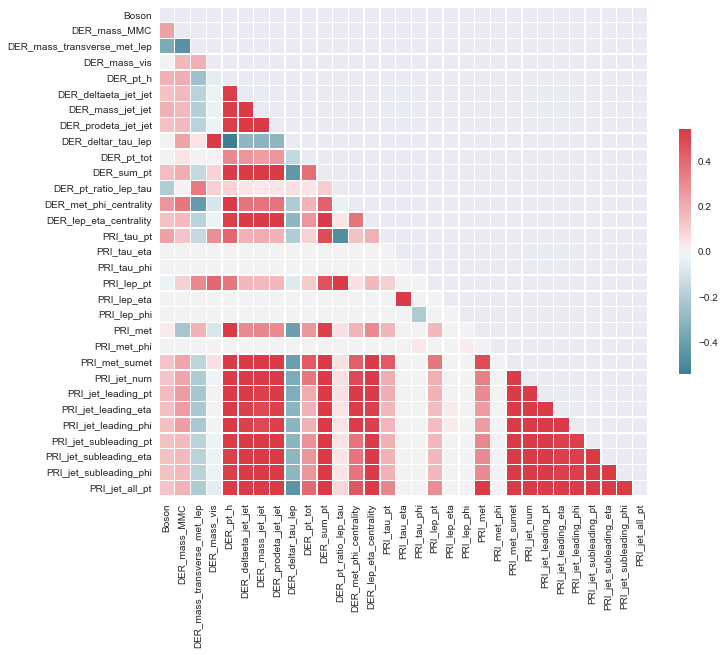

In [162]:
complete_data = np.append(np.array([y]).T,x,axis=1)
corr  = np.corrcoef(complete_data.T)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
xticks = np.append('Boson',labels)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, xticklabels=xticks, yticklabels=xticks);

array([ 138.47 ,   51.655,   97.827, ...,   99.405,    0.   ,    0.   ])

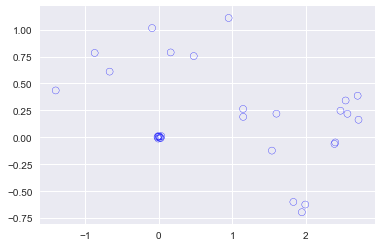

In [134]:
x_no = x.copy()
x_no[x_no == -999] = 0.0
corr = np.corrcoef(x_no.T)
eigenvalues, eigenvectors = la.eigh(corr)
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
projection_s = corr.dot(eigenvectors[:,:4])
plt.scatter(projection_s[:,0],projection_s[:,1],facecolors='none',edgecolors='b')
# projection_b = corr.dot(eigenvectors[:,:4])
# plt.scatter(projection_b[:,0],projection_b[:,1],facecolors='none',edgecolors='g')

In [161]:
def summary_table(data):
    data = data.copy()
    data[data==-999] = np.nan
    data = {
        'Label':labels,
        'Min':np.nanmin(data,axis=0),
        'Q1':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Q3':np.nanpercentile(data, 25, interpolation='midpoint', axis=0),
        'Max':np.nanmax(data,axis=0),
        'Median':np.nanmedian(data,axis=0),
        'Mean':np.nanmean(data,axis=0),
        'Std':np.nanstd(data,axis=0),
        'Missing': np.count_nonzero(np.isnan(data),axis=0)/data.shape[0]
    }
    numberFormatter =  NumberFormatter(format='0.000')
    source = ColumnDataSource(data)
    label_colum = TableColumn(field='Label', title='Label', width=150)
    columns = [label_colum] + [TableColumn(field=label, title=label, formatter=numberFormatter, width=80)\
               for label in [k for k in data.keys() if k != 'Label']]
    data_table = DataTable(source=source, columns=columns, width=900, height = 800)
    show(widgetbox(data_table, sizing_mode = 'scale_both'))
    
summary_table(x)

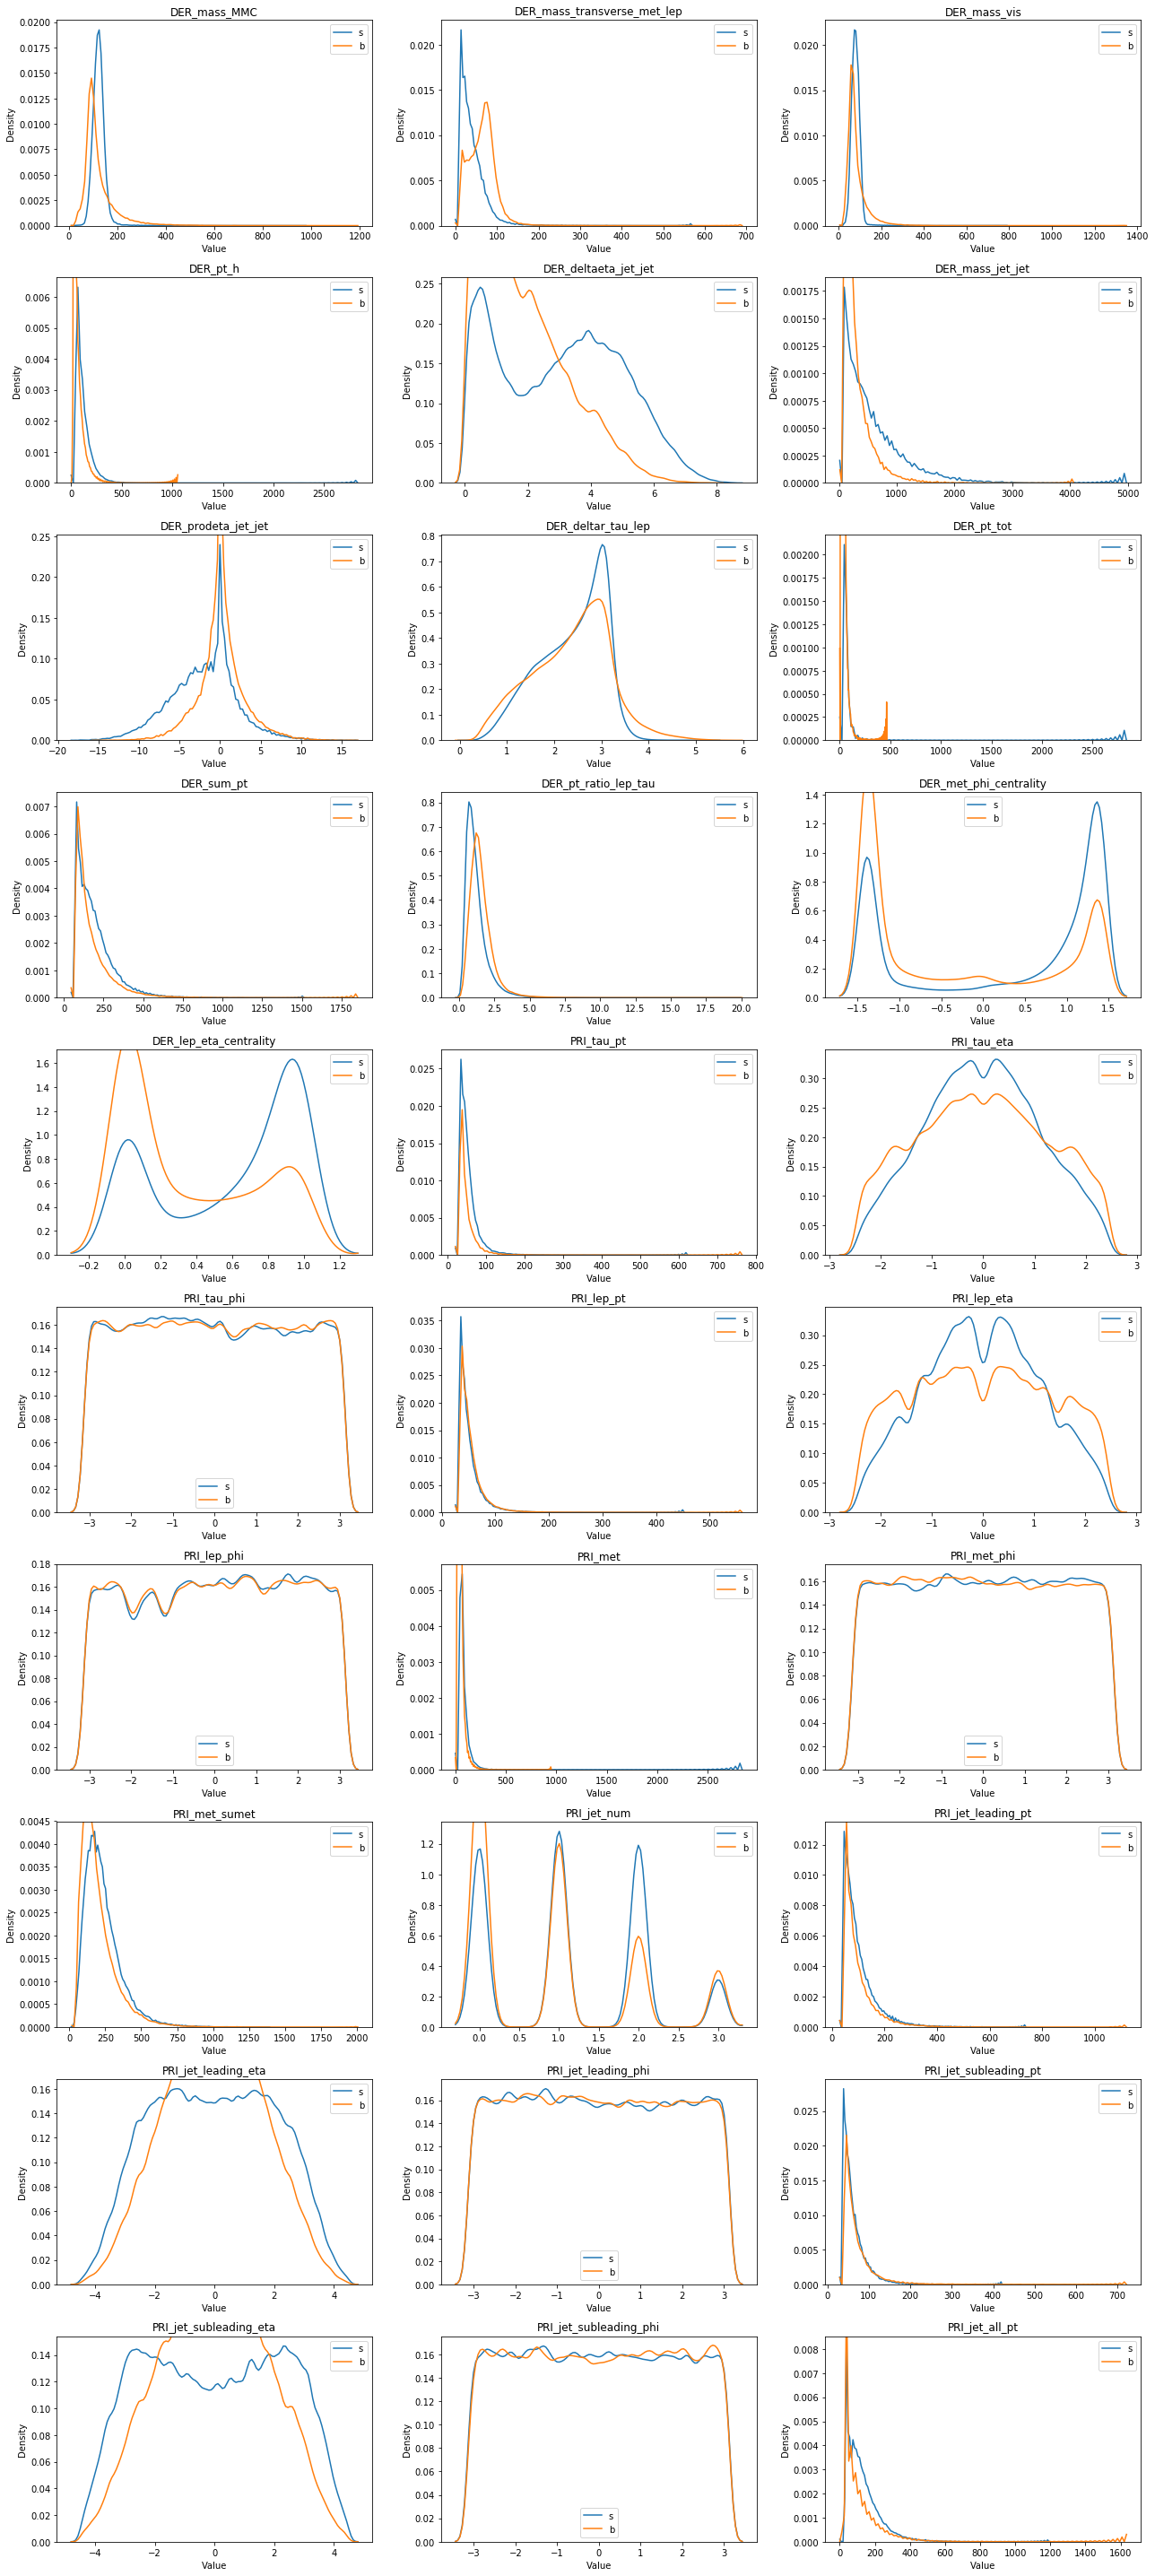

In [7]:
fig_size = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [18,40]
for i, label in enumerate(labels):
    plt.subplot(10,3,i+1)
    values_s = x[y == 1]
    values_s = values_s[:,i]
    values_s[values_s==-999] = np.nan
#     plt.hist(values_s[~np.isnan(values_s)], label='s', histtype='step')
    sns.kdeplot(values_s[~np.isnan(values_s)], label='s', bw=0.1)
    
    values_b = x[y == -1]
    values_b = values_b[:,i]
    values_b[values_b==-999] = np.nan
#     plt.hist(values_b[~np.isnan(values_b)], label='b', histtype='step')
    sns.kdeplot(values_b[~np.isnan(values_b)], label='b',bw=0.1)
    plt.title(label)
    plt.ylabel('Density')
    plt.xlabel('Value')
plt.tight_layout()

In [15]:
def cross_validation_visualization(lambds, mse_tr, mse_te):
    """visualization the curves of mse_tr and mse_te."""
    plt.semilogx(lambds, mse_tr, marker=".", color='b', label='train error')
    plt.semilogx(lambds, mse_te, marker=".", color='r', label='test error')
    plt.xlabel("lambda")
    plt.ylabel("mse")
    plt.title("cross validation")
    plt.legend(loc=2)
    plt.grid(True)
def x_y_for_jet(x, y, n, mass=True):
    jet_num = x[:, 22] == n
    if n == 2:
        jet_num = jet_num | (x[:, 22] == 3)
    if mass:
        jet_num = jet_num & (x[:, 0] != -999)
    else:
        jet_num = jet_num & (x[:, 0] == -999)
    x_jet = x[jet_num]
    y_jet = y[jet_num]
    jet_mean = np.mean(x_jet, axis=0)
    x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
    return x_jet, y_jet

# Model building

In [3]:
y, x, ids = load_csv_data('../data/train.csv')
# x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

## Baseline
We create our baselines using cross validation, since it is only used to find the best value for a particular parameter using the whole data.
### Least squares GD

In [19]:
gammas = np.logspace(-3,-1.0,10)
mse_tr = []
mse_te = []
y_scaled = (y+1)/2.0
for gamma in gammas:
    mse_tr_, mse_te_ = cross_validation(y_scaled, x, 5, least_squares_GD, compute_mse, {'initial_w' : np.zeros(x.shape[1] + 1), 'max_iters':500, 'gamma':gamma})
    mse_tr.append(mse_tr_)
    mse_te.append(mse_te_)
cross_validation_visualization(gammas, mse_tr, mse_te)

NameError: name 'compute_gradient' is not defined

In [20]:
print(np.vstack([gammas,mse_tr,mse_te]))

ValueError: all the input array dimensions except for the concatenation axis must match exactly

## Least squares SGD

In [23]:
gammas = np.logspace(2,5,5)
mse_tr = []
mse_te = []
for gamma in gammas:
    mse_tr_, mse_te_ = cross_validation(y, x, 10, least_squares_SGD, compute_mse, {'initial_w' : np.zeros(x.shape[1]  + 1), 'max_iters':10000, 'gamma':gamma})
    mse_tr.append(mse_tr_)
    mse_te.append(mse_te_)
cross_validation_visualization(gammas, mse_tr, mse_te)

KeyboardInterrupt: 

## Least squares normal equations

In [26]:
rmse_tr_, rmse_te_ = cross_validation(y, x, 5, least_squares, compute_mse, seed=5)
print(rmse_tr_, rmse_te_)

0.255048 0.255212


## Ridge regression

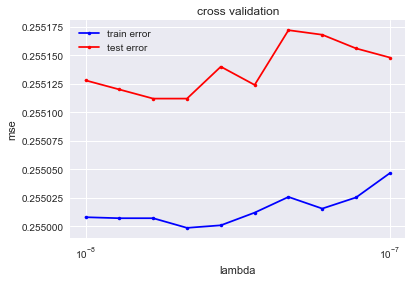

In [42]:
lambdas = np.logspace(-8,-7,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, x, 10, ridge_regression, compute_mse, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [39]:
rmse_tr

[0.25500800000000001,
 0.25500711111111113,
 0.25500711111111107,
 0.25499866666666665,
 0.25500088888888889,
 0.25501199999999996,
 0.2550257777777778,
 0.25501555555555555,
 0.25502533333333333,
 0.2550466666666667]

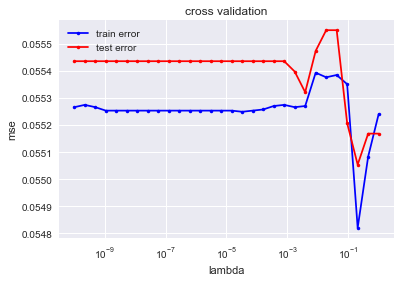

In [73]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 0, False)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

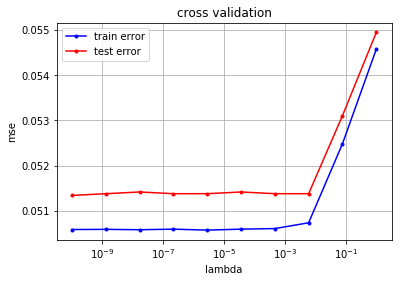

In [24]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x,y, 0, False)
rmse_tr = []
rmse_te = []
degree = 5
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [26]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.0513399693721
1e-10


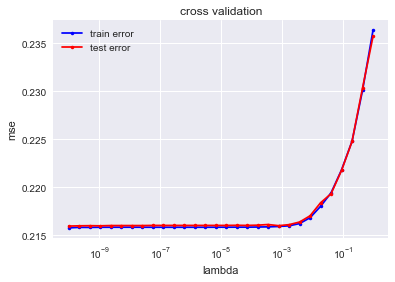

In [74]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 0, True)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

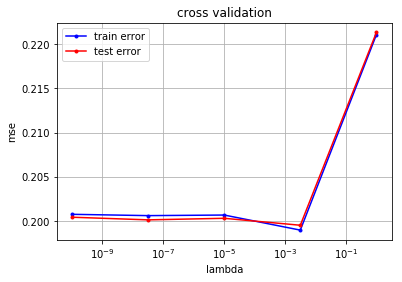

In [32]:
lambdas = np.logspace(-10,0,5)
x_jet, y_jet = x_y_for_jet(x,y, 0, True)
rmse_tr = []
rmse_te = []
degree = 4
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [33]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.199512129015
0.00316227766017


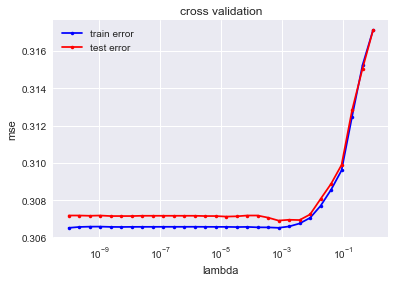

In [100]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 1, True)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

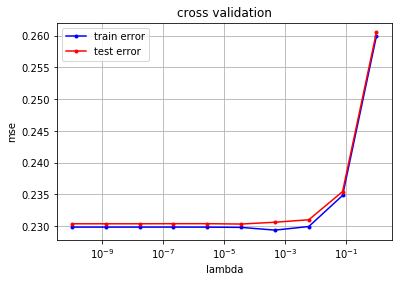

In [45]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x,y, 1, True)
rmse_tr = []
rmse_te = []
degree = 6
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [44]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.226164618462
1.29154966501e-09


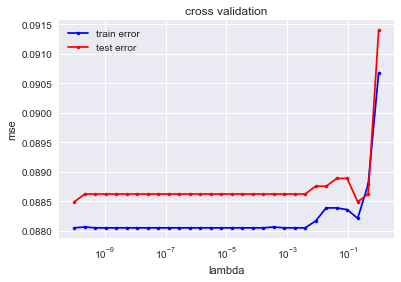

In [79]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 1, False)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

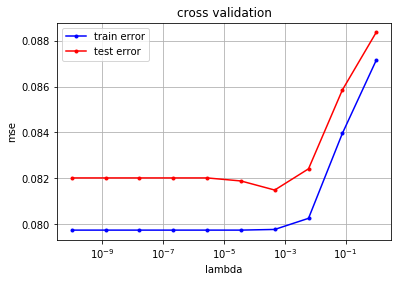

In [51]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x,y, 1, False)
rmse_tr = []
rmse_te = []
degree = 5
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [52]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.0814814814815
0.000464158883361


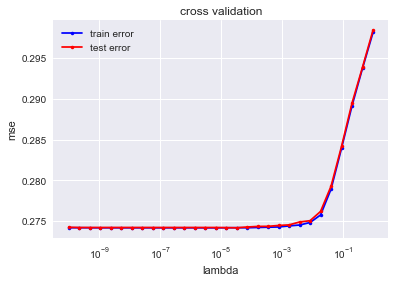

In [80]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 2, True)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

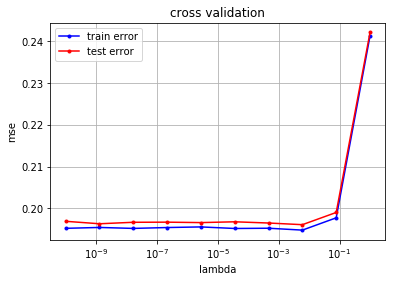

In [74]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x,y, 2, True)
rmse_tr = []
rmse_te = []
degree = 7
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [75]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.196123917193
0.00599484250319


In [67]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.19618264572
0.00316227766017


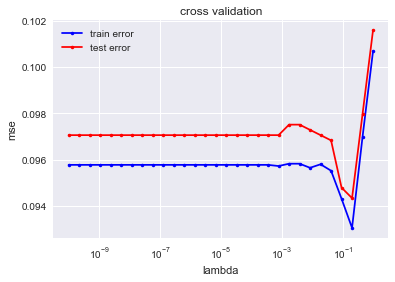

In [81]:
lambdas = np.logspace(-10,0,30)
x_jet, y_jet = x_y_for_jet(x,y, 2, False)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, accuracy, {'lambda_': lambda_}, seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

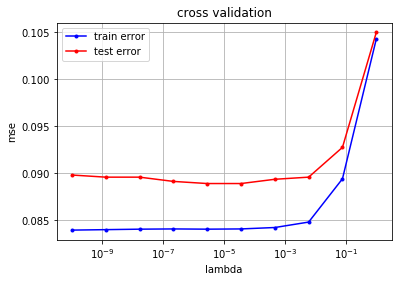

In [81]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x,y, 2, False)
rmse_tr = []
rmse_te = []
degree = 3
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [79]:
print(np.min(rmse_te))
print(lambdas[np.argmin(rmse_te)])

0.0889140271493
2.78255940221e-06


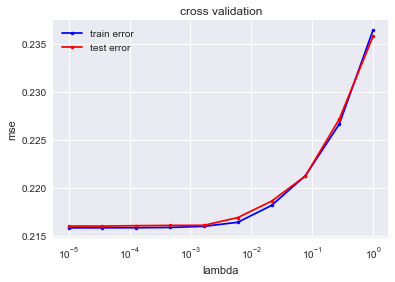

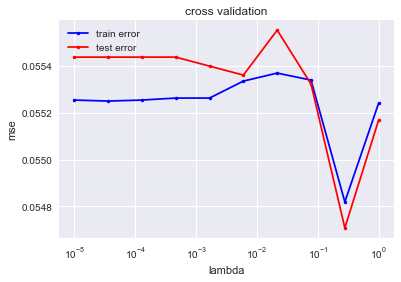

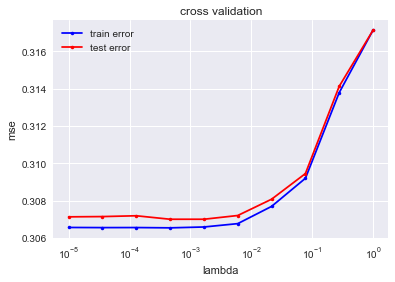

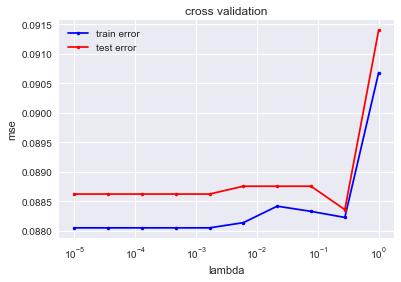

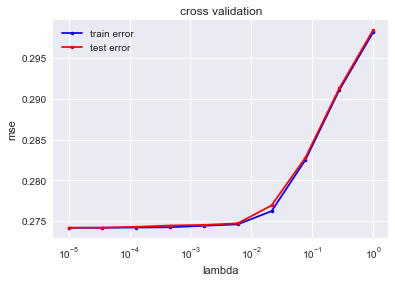

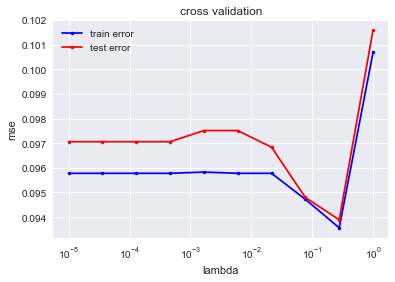

In [54]:
lambdas = np.logspace(-5,0,10)

degree = 6
def x_y_for_jet(x, y, n, mass=True):
    jet_num = x[:, 22] == n
    if n == 2:
        jet_num = jet_num | (x[:, 22] == 3)
    if mass:
        jet_num = jet_num & (x[:, 0] != -999)
    else:
        jet_num = jet_num & (x[:, 0] == -999)
    x_jet = x[jet_num]
    y_jet = y[jet_num]
    jet_mean = np.mean(x_jet, axis=0)
    x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
    return x_jet, y_jet
i = 0
for n in range(3):
    for mass in [True, False]:
        x_jet, y_jet = x_y_for_jet(x, y, n, mass)
        plt.figure(n*2+int(mass))
        rmse_tr = []
        rmse_te = []
        for lambda_ in lambdas:
            rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression, compute_mse, {'lambda_': lambda_}, seed=5)
            rmse_tr.append(rmse_tr_)
            rmse_te.append(rmse_te_)
        cross_validation_visualization(lambdas, rmse_tr, rmse_te)
        plt.plot()
        i += 1

2


## Logisitic regression

/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:35: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))


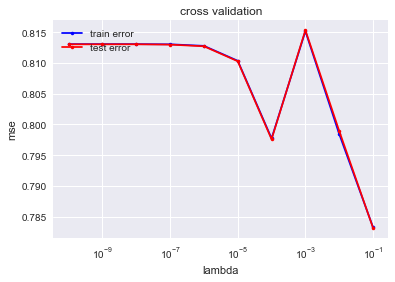

In [53]:
lambdas = np.logspace(-10,-1,10)
rmse_tr = []
rmse_te = []
y_scaled = (y+1)/2.0
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_scaled, x, 5, logistic_regression, compute_loss_logistic, {'initial_w': np.zeros(x.shape[1] + 1), 'max_iters': 10000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:35: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))
/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:20: RuntimeWarning: overflow encountered in exp
  return 1.0/(np.exp(-t)+1)


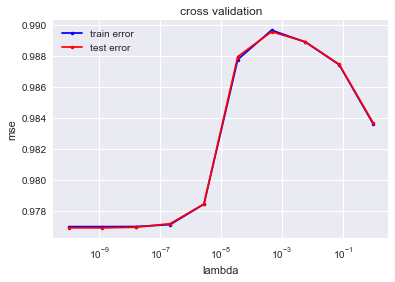

In [89]:
lambdas = np.logspace(-10,0,10)
y_scaled = (y+1)/2.0
x_jet, y_jet = x_y_for_jet(x,y_scaled, 0, False)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, logistic_regression, accuracy, {'initial_w': np.zeros(x_jet.shape[1] + 1), 'max_iters': 100000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

## Regularized logistic regression

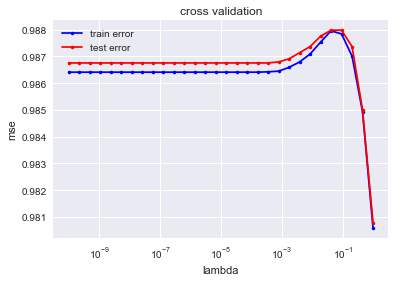

In [85]:
lambdas = np.logspace(-10,0,30)
y_scaled = (y+1)/2.0
x_jet, y_jet = x_y_for_jet(x,y_scaled, 0, False)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 4, reg_logistic_regression, accuracy, {'lambda_': lambda_,'initial_w': np.zeros(x_jet.shape[1] + 1), 'max_iters': 10000, 'gamma': 0.0081491274690207397})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

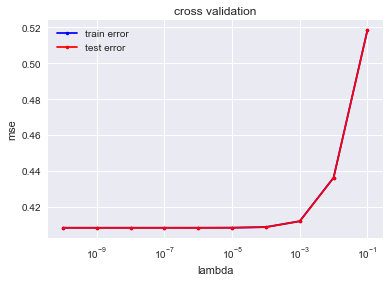

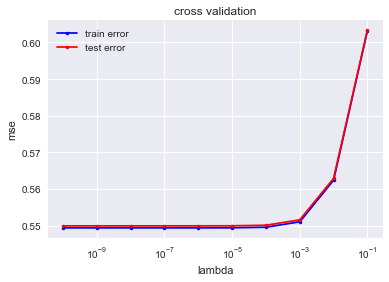

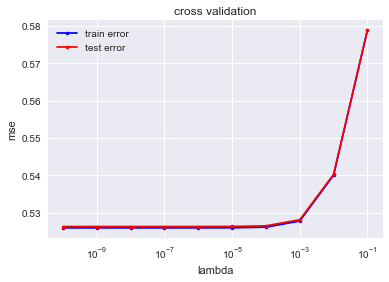

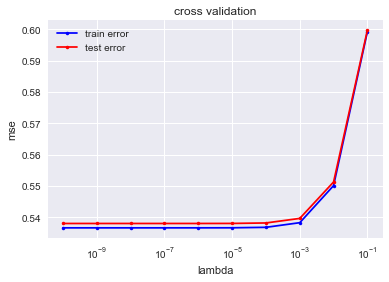

In [58]:
lambdas = np.logspace(-10,-1,10)
def x_y_for_jet(x, y):
    for n in range(4):
        jet_num = x[:, 22] == n
        x_jet = x[jet_num]
        y_jet = y[jet_num]
        jet_mean = np.mean(x_jet, axis=0)
        x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
        yield x_jet, y_jet
y_scaled = (y+1)/2.0

i = 0
for x_jet, y_jet in x_y_for_jet(x,y_scaled):
    rmse_tr = []
    rmse_te = []
    for lambda_ in lambdas:
        rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 4, reg_logistic_regression, compute_loss_logistic_reg, {'lambda_': lambda_,'initial_w': np.zeros(x_jet.shape[1] + 1), 'max_iters': 10000, 'gamma': 0.0081491274690207397}, {'lambda_': lambda_})
        rmse_tr.append(rmse_tr_)
        rmse_te.append(rmse_te_)
    plt.figure(i)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.plot()
    i += 1

In [144]:
rmse_te

[0.51104651965027259,
 0.51104669898363742,
 0.51104699812787313,
 0.51104749712499653,
 0.51104832948764034,
 0.51104971791108489,
 0.51105203382606401,
 0.51105589668511742,
 0.51106233943238422,
 0.5110730841074288]

## Separating datasets

In [95]:
def index_of(label):
    return np.where(labels == label)[0][0]
print(index_of('PRI_jet_num'))
print(index_of('DER_deltaeta_jet_jet'))
print(index_of('DER_prodeta_jet_jet'))
print(index_of('DER_lep_eta_centrality'))
print(index_of('PRI_jet_leading_pt'))
print(index_of('PRI_jet_leading_eta'))
print(index_of('PRI_jet_leading_phi'))
print(index_of('PRI_jet_subleading_pt'))
print(index_of('PRI_jet_subleading_eta'))
print(index_of('PRI_jet_subleading_phi'))
print(index_of('DER_lep_eta_centrality'))
labels[22]

22
4
6
12
23
24
25
26
27
28
12


'PRI_jet_num'

In [139]:
def x_y_for_jet(n):
    jet_num = x[:, 22] == n
    x_jet = x[jet_num]
    y_jet = y[jet_num]
    jet_mean = np.mean(x_jet, axis=0)
    x_jet = x_jet[:, (jet_mean != -999) & (jet_mean != 0) & (jet_mean != n)]
    return x_jet, y_jet
jet_num = x[:, 22] == 0
x_jet_0 = x[jet_num]
y_jet_0 = y[jet_num]
jet_0_mean = np.mean(x_jet_0, axis=0)
np.where(jet_0_mean != 0)[0]
x_jet_0 = x_jet_0[:,(jet_0_mean != -999) & (jet_0_mean != 0)]
x_y_for_jet(3)[0].shape

(22164, 29)

At 0
At 1
At 2
At 3


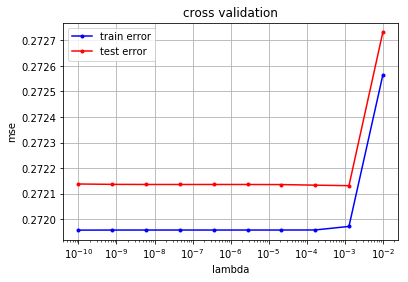

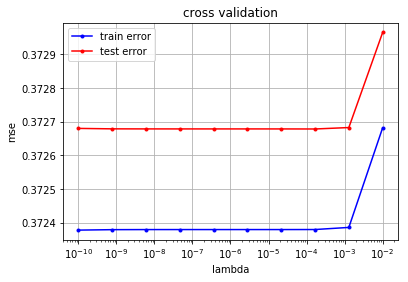

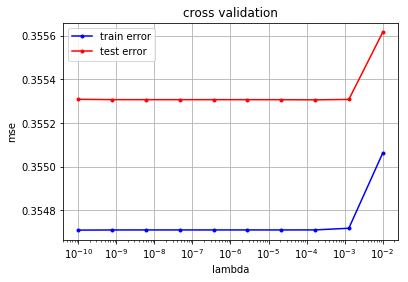

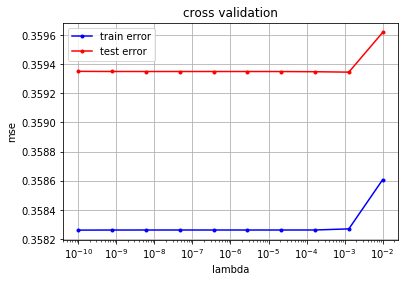

In [136]:
lambdas = np.logspace(-10,-2,10)
for n in range(4):
    rmse_tr = []
    rmse_te = []
    x_jet, y_jet = x_y_for_jet(n)
    for lambda_ in lambdas:
        rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 5, ridge_regression, compute_mse, {'lambda_': lambda_}, seed=5)
        rmse_tr.append(rmse_tr_)
        rmse_te.append(rmse_te_)
    plt.figure(n)
    cross_validation_visualization(lambdas, rmse_tr, rmse_te)
    plt.plot()
    print("At", n)

In [24]:
# y, x, ids = load_csv_data('../data/train.csv', sub_sample=True)
y, x, ids = load_csv_data('../data/train.csv')
filter_ = [idx for idx, label in enumerate(labels) if not 'phi' in label]
# x = x[:, filter_]
x = (x - np.mean(x, axis=0))/np.std(x, axis=0)
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

In [22]:
y = (y+1)/2.0

In [19]:
lambdas = np.logspace(-7,-1,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, logistic_regression, compute_loss_logistic, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 100000, 'gamma': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

/home/raph/school/2017-2018/ml/ML_project/scripts/helpers.py:33: RuntimeWarning: divide by zero encountered in log
  loss = np.sum(y.T @ np.log(sigma_xn_w) + (1-y).T @ np.log(1-sigma_xn_w))


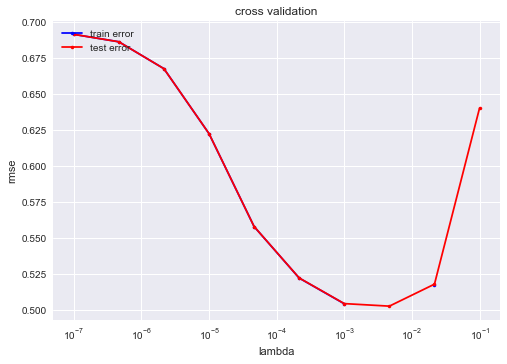

In [20]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [17]:
min(rmse_te)

0.50042407943911393

In [21]:
min(rmse_te)

0.50252559564073895

In [33]:
lambdas = np.logspace(-10,-1,5)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, reg_logistic_regression, compute_loss_logistic_reg, {'lambda_': lambda_,'initial_w': np.zeros(tx.shape[1]), 'max_iters': 10000, 'gamma': 0.001}, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

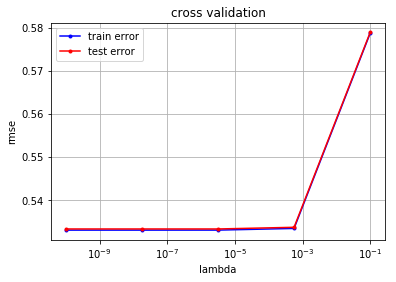

In [34]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [111]:
lambdas[np.argmin(rmse_te)]

0.001

In [48]:
lambdas = np.logspace(-10,-2,10)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, x, 5, ridge_regression, compute_mse, {'lambda_': lambda_})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

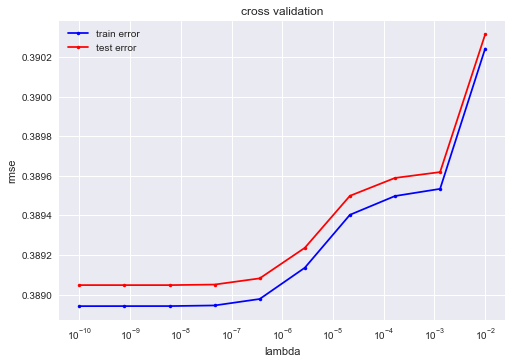

In [49]:
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

In [45]:
rmse_tr_, rmse_te_ = cross_validation(y, x, 5, least_squares, compute_mse)
print(rmse_tr_,rmse_te_)

0.388940931758 0.389052278846


0.38904858595820857

In [61]:
lambdas = np.logspace(-10,-1,5)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_GD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 10000, 'gamma': 0.1})
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)

In [79]:
rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_GD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 1000, 'gamma': 0.01})
print(rmse_tr_,rmse_te_)

Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
Stopped at 999 iterations
0.0858090286377 0.0858265140568


In [84]:
rmse_tr_, rmse_te_ = cross_validation(y, tx, 5, least_squares_SGD, compute_mse, {'initial_w': np.zeros(tx.shape[1]), 'max_iters': 1000000, 'gamma': 0.01})
print(rmse_tr_,rmse_te_)

0.160224664826 0.160226146812


In [124]:
lambdas = np.logspace(-10,0,30)
rmse_tr = []
rmse_te = []
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation_group(y, x, 10, ridge_regression, [{'lambda_': lambda_}] * 6)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)

IndexError: boolean index did not match indexed array along dimension 1; dimension is 18 but corresponding boolean dimension is 30

In [188]:
args = [{'lambda_': 0.031, 'degree': 4}, {'lambda_': 1e-10, 'degree': 5}, {'lambda_': 1.29e-9, 'degree': 6},\
       {'lambda_': 0.00046, 'degree': 5}, {'lambda_': 0.00316, 'degree': 7}, {'lambda_': 2.78255e-6, 'degree': 3}]
x_filtered = x_normalized[:, filter_]
cross_validation_group(y, x_filtered, 10, ridge_regression_with_poly, args)

(0.17775777777777776, 0.17881199999999994)

In [182]:
filter_ = [idx for idx, label in enumerate(labels) if not 'Pri_tau_phi' in label or not 'PRI_lep_phi' in label]

In [187]:
def log_normalize(x):
    if x > 0:
        return np.log(x)
    return x
normalize = [idx for idx, label in enumerate(labels) if label in ['DER_mass_vis', 'PRI_tau_pt', 'PRI_lep_pt',\
                                                                  'PRI_met', 'PRI_jet_subleading_pt', 'DER_mass_MMC',\
                                                                  'DER_mass_vis', 'DER_pt_tot', 'DER_sum_pt',\
                                                                  'DER_pt_ratio_lep_tau', 'PRI_met_sumet',\
                                                                  'PRI_jet_leading_pt']]
# np.apply_along_axis(log_normalize, 0, x[:, normalize])
log_normalize = np.vectorize(log_normalize)
x_normalized = x.copy()
x_normalized[:, normalize] = log_normalize(x_normalized[:, normalize])

11


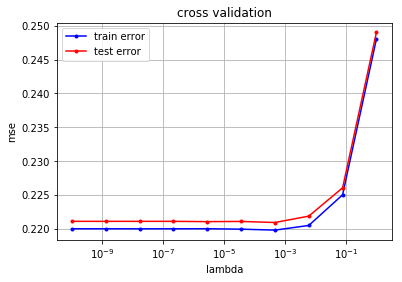

In [184]:
lambdas = np.logspace(-10,0,10)
x_jet, y_jet = x_y_for_jet(x_normalized,y, 1, True)
rmse_tr = []
rmse_te = []
degree = 6
for lambda_ in lambdas:
    rmse_tr_, rmse_te_ = cross_validation(y_jet, x_jet, 10, ridge_regression_with_poly, accuracy_with_poly, {'lambda_': lambda_, 'degree': degree}, {'degree': degree},  seed=5)
    rmse_tr.append(rmse_tr_)
    rmse_te.append(rmse_te_)
cross_validation_visualization(lambdas, rmse_tr, rmse_te)